### Usando técnica de undersampling
Nessa técnica diminuimos a quantidade dos dados predominantes. Não é tão recomendado por ter muita perda de informações, mas para fins de estudo, vale o teste :)

In [1]:
# imports necessarios 
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler 
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.appName('credit-card-undersampling').getOrCreate()

In [3]:
df = spark.read.csv('datasets/creditcard.csv', inferSchema=True, header=True)

In [4]:
# usaremos a função sample do proprio pyspark que retorna subconjuntos de amostras do dataset 
major_df2 = df.filter(col("Class") == 0)
minor_df2 = df.filter(col("Class") == 1)
ratio2 = int(major_df2.count()/minor_df2.count())
sampled_maj_df = major_df2.sample(False, 1/ratio2) # no caso de oversampling a gente multiplica, aqui nos dividimos para diminuir a quantidade de dados 
comb_df = sampled_maj_df.unionAll(minor_df2)


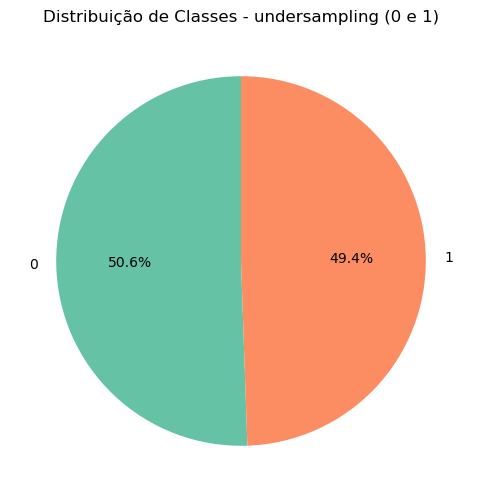

In [5]:
class_counts = comb_df.groupBy("Class").count().toPandas()
plt.figure(figsize=(6, 6))
plt.pie(class_counts['count'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title("Distribuição de Classes - undersampling (0 e 1)")
plt.show()

In [27]:
counts = comb_df.groupBy('Class').count()
counts.show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|  503|
|    1|  492|
+-----+-----+



### Transformação dos dados em vetores para poder colocar no modelo

In [6]:
# transformando em vetores para poder colocar no modelo depois 
assembler_under = VectorAssembler(inputCols=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], outputCol='features')
output_under = assembler_under.transform(comb_df)
under_data = output_under.select('features', 'Class')
under_data.show()

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[333.0,-1.6859867...|    0|
|[426.0,-0.4241260...|    0|
|[890.0,-0.4911092...|    0|
|[926.0,0.82999787...|    0|
|[1805.0,-1.992552...|    0|
|[2571.0,-0.616636...|    0|
|[2794.0,-0.668830...|    0|
|[5301.0,1.2011734...|    0|
|[5325.0,-0.624492...|    0|
|[6536.0,1.2568917...|    0|
|[7071.0,1.1534035...|    0|
|[8177.0,-0.610306...|    0|
|[9029.0,-0.864906...|    0|
|[9549.0,-1.068555...|    0|
|[11004.0,1.226029...|    0|
|[11345.0,1.249604...|    0|
|[14459.0,1.147235...|    0|
|[14489.0,-0.41117...|    0|
|[17439.0,1.097525...|    0|
|[17997.0,-1.01414...|    0|
+--------------------+-----+
only showing top 20 rows



In [7]:
# dividindo em conjunto de treino e teste 
train_under, test_under = under_data.randomSplit([0.7, 0.3])

### Criação e treinamento dos modelos

In [8]:
# aplicando no modelo 
# usando logistic regression primeiro 
lr_under = LogisticRegression(labelCol='Class')

# fit the model 
lr_fitted_under = lr_under.fit(train_under) 
lr_sum_under = lr_fitted_under.summary
training_lr_under = lr_sum_under.predictions.describe().show()

+-------+------------------+------------------+
|summary|             Class|        prediction|
+-------+------------------+------------------+
|  count|               710|               710|
|   mean|0.4859154929577465|0.4647887323943662|
| stddev|0.5001539324819102| 0.499110235554576|
|    min|               0.0|               0.0|
|    max|               1.0|               1.0|
+-------+------------------+------------------+



In [9]:
results_under = lr_fitted_under.transform(test_under) # retorna uma coluna nova com predicoes 

In [10]:
results_under.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Class|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[426.0,-0.4241260...|    0|[1.76071689278444...|[0.85329942322264...|       0.0|
|[2571.0,-0.616636...|    0|[1.86730619002071...|[0.86614627339832...|       0.0|
|[9549.0,-1.068555...|    0|[3.31624627419267...|[0.96498196758970...|       0.0|
|[11004.0,1.226029...|    0|[3.17960702892773...|[0.96005960023082...|       0.0|
|[11345.0,1.249604...|    0|[2.34295868898345...|[0.91237291692753...|       0.0|
|[14489.0,-0.41117...|    0|[107.623413786305...|           [1.0,0.0]|       0.0|
|[18612.0,-0.65807...|    0|[3.08042776445211...|[0.95607815110164...|       0.0|
|[19615.0,-1.56714...|    0|[2.12236751017495...|[0.89305824957649...|       0.0|
|[20932.0,1.278205...|    0|[4.00153540110709...|[0.98204088931550...|       0.0|
|[21689.0,1.1850

In [13]:
# usando outros metodos de classificacao 
 
rfc = RandomForestClassifier(labelCol='Class', featuresCol='features', numTrees=100)
dtc = DecisionTreeClassifier(labelCol='Class', featuresCol='features')
gbt = GBTClassifier(labelCol='Class', featuresCol='features')


In [14]:
# treinando os modelos 

rfc_train = rfc.fit(train_under)
dtc_train = dtc.fit(train_under)
gbt_train = gbt.fit(train_under)

In [15]:
# previsoes 

rfc_preds = rfc_train.transform(test_under)
dtc_preds = dtc_train.transform(test_under)
gbt_preds = gbt_train.transform(test_under)

### Avaliação das métricas de cada modelo

In [29]:
# avaliando metricas do modelo 
eval = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
acc = eval.evaluate(results_under)
print(f'Acurácia LR: {acc}')

eval = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='recallByLabel')
recall = eval.evaluate(results_under)
print(f'Recall LR: {recall}')


Acurácia LR: 0.9403508771929825
Recall LR: 0.9637681159420289


Random Forest

In [22]:
# metricas de cada modelo 
acc_rfc = eval.evaluate(rfc_preds)
print(f'Acurácia: {acc_rfc}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall = evaluator.evaluate(rfc_preds)
print(f"Recall: {recall}")

Acurácia: 0.9927536231884058
Recall: 0.9927536231884058


Decision Tree

In [24]:

acc_dtc = eval.evaluate(dtc_preds)
print(f'Acurácia: {acc_dtc}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall = evaluator.evaluate(dtc_preds)
print(f"Recall: {recall}")

Acurácia: 0.9130434782608695
Recall: 0.9130434782608695


Gradient Boosting

In [26]:
acc_gbt = eval.evaluate(gbt_preds)
print(f'Acurácia: {acc_gbt}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall = evaluator.evaluate(gbt_preds)
print(f"Recall: {recall}")

Acurácia: 0.9130434782608695
Recall: 0.9130434782608695


O undersampling também pode levar ao overfitting, uma vez que a base de dados pode ter ficado muito pequena (no caso ficamos com 500 amostrar de cada classe). A frequência fica a mesma, mas a distribuição dos dados pode afetar no modelo e avaliando as métricas, todos estão com acurácia maior que 90%,a tingindo até 99% - no caso do random forest.